### Basic principles
    1. simulate the output of a monochromatic incident pulse w/ & w/o shapeError up to HHLM4.
    2. extract the phase information of the output beams w/ & w/o shapeError, to calculate the phase difference needed.
    3. transform the phase difference into a thickness profile, and add phase plate into beamline.
    4. simulate the results w/ & w/o phase plate.
    

In [1]:
from Functions import *
import winsound

In [2]:
''' Beam parameters '''
N = 1024			# number of sampling points
E0 = 17795			# photon energy [eV]
tau = 400			# pulse duration [fs]
window = 50000		# total simulation time window [fs]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 650-26
}

In [3]:
##### I/O
dir_out = 'output/'; make_dir(dir_out)
dir_ev = dir_out + '{}eV/'.format(E0); make_dir(dir_ev)
dir_case = dir_ev + 'beam_profiles/'; make_dir(dir_case)

print('\nCWD:',dir_case)

path exists
path exists
path exists

CWD: output/17795eV/beam_profiles/


### Calculate beam profiles after each optics along the beamline for crystal dimension calculation and slit width calculation

In [4]:
def define_beamline0(
    E0, m1_p=185.0, m2_p=175.5,
    HHLM_type='2DCM', HHLM_offset=20e-3, pair_distance=200e-3,
    slit_width=3e-6, f1=10.0, f2=10.0,
    hkl1 = [1,1,1], alphaAsym1 = 0.0,
    hkl2 = [2,2,0], alphaAsym2 = 0.0,
    hkl3 = [5,5,5], alphaAsym3 = 15.0,
    shapeErrors=[None for i in range(6)],
    l_crystal=[1e-1 for i in range(6)],
    w_crystal = [5e-3 for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=5e-3, N=512)
    
    Telescope_devices = define_Telescope(E0, m1_p=m1_p, m1_q=25.6, m2_p=m2_p)
    
    if HHLM_type == '2DCM':
        HHLM_devices = define_HHLM_2DCM(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    elif HHLM_type == 'Zigzag':
        HHLM_devices = define_HHLM_Zigzag(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    
    HRM_devices = define_HRM(E0, f1=f1, f2=f2, slit_width=slit_width,
                            hkl=hkl3, alphaAsym=alphaAsym3,
                            shapeErrors=shapeErrors,
                            l_crystal=l_crystal,
                            w_crystal=w_crystal)

    all_devices = [im_input] + Telescope_devices + HHLM_devices + HRM_devices
    
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return all_devices, mono_beamline


In [5]:
##### simulation parameters
m1_p = 185.0; m2_p = 141.064
slit_width = 1e-1
f1 = 10.0; f2 = 10.0            # f1: crystal-mirror distance, f2: mirror focal distance

HHLM_type = '2DCM'              # 2DCM or Zigzag
HHLM_offset=20e-3
pair_distance=200e-3
hkl1 = [1,1,1]; alphaAsym1 = 3.0    # asymmetry angle for the 1st pair of HHLM crystal
hkl2 = [2,2,0]; alphaAsym2 = 0.0    # ````````````````````````2nd pair of HHLM crystal
hkl3 = [5,5,5]; alphaAsym3 = 15.0   # ````````````````````````2nd and 3rd HRM crystal

shapeErrors = [None for i in range(6)]
l_crystal = [1e-1 for i in range(6)]
w_crystal = [5e-3 for i in range(6)]

mono_devices, mono_beamline = define_beamline0(E0,
                               m1_p=m1_p, m2_p=m2_p, HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=shapeErrors,
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)


b 0.36
b 2.76
b 1.00
b 1.00
b 1.00
b 2.34
slit width: 100000.0 um
b 0.43
b 1.00


In [6]:
%%capture capt
# list of crystals
crystals = np.array(['HHLM1', 'HHLM2', 'HHLM3', 'HHLM4', 'C1', 'C2']); n_crys = len(crystals)

b1 = beam.Beam(beam_params=beam_params)
b2 = mono_beamline.propagate_beamline(b1)


In [7]:
# calculate beam FWHM after each crystal
wx1, wy1 = mono_beamline.im_after_HHLM1.beam_analysis(mono_beamline.im_after_HHLM1.get_profile_x(), mono_beamline.im_after_HHLM1.get_profile_y())[2:4]
wx2, wy2 = mono_beamline.im_after_HHLM2.beam_analysis(mono_beamline.im_after_HHLM2.get_profile_x(), mono_beamline.im_after_HHLM2.get_profile_y())[2:4]
wx3, wy3 = mono_beamline.im_after_HHLM3.beam_analysis(mono_beamline.im_after_HHLM3.get_profile_x(), mono_beamline.im_after_HHLM3.get_profile_y())[2:4]
wx4, wy4 = mono_beamline.im_after_HHLM4.beam_analysis(mono_beamline.im_after_HHLM4.get_profile_x(), mono_beamline.im_after_HHLM4.get_profile_y())[2:4]
wx5, wy5 = mono_beamline.im_after_C1.beam_analysis(mono_beamline.im_after_C1.get_profile_x(), mono_beamline.im_after_C1.get_profile_y())[2:4]
wx6, wy6 = mono_beamline.im_after_C2.beam_analysis(mono_beamline.im_after_C2.get_profile_x(), mono_beamline.im_after_C2.get_profile_y())[2:4]

beta0s = []
for device in mono_devices:
    if device.name in crystals:
        beta0s.append(device.beta0)

# crystal lengths (long) and widths (short) [m]
beam_size = np.array([wx1, wx2, wx3, wx4, wx5, wx6])    # FWHM
l_crystal = np.divide(beam_size*2, np.sin(beta0s))
w_crystal = np.array([wy1, wy2, wy3, wy4, wy5, wy6])*2

# print crytal properties
braggs = []
asyms = []

for device in mono_devices:
    if device.name in crystals:
        braggs.append(np.rad2deg(device.bragg))
        asyms.append(np.rad2deg(device.alphaAsym))
print('beam size[mm]: {}'.format(beam_size*1e3))
print('bragg angle', np.round(braggs,3))
print('asymmetry', asyms)
print('footprint [mm]',l_crystal*1e3/2)

beam size[mm]: [3.60889423 1.30593038 1.30592781 1.30592709 1.3058511  0.55829873]
bragg angle [ 6.381  6.38  10.454 10.454 33.747 33.747]
asymmetry [-3.0000000000000004, 3.0000000000000004, -0.0, 0.0, 0.0, 14.999999999999998]
footprint [mm] [22.14418197 22.14397739  7.19742553  7.19742158  2.35062902  1.73693578]


In [8]:
# calculate slit width
def calc_slit_width(inbeam, lmbd, foc):
    # inbeam is the beamsize (2x FWHM) after Crystal 2
    # lmbd is wavelength of photon
    # asym is asymmetry angle of Crystal 2
    # foc is Mir1/Lens1 focal distance
    # returns mono focus size in [m] at the Fourier plane
    slt = 2*np.log(2)*lmbd*foc/np.pi/inbeam
    return 2.11 * slt    # 2x FWHM with some error (~factor of 5%)

slit_width = calc_slit_width(wx6*2, b2.lambda0, mono_beamline.mir1.q)
print('calculated slit width: {}um'.format(round(slit_width*1e6,2)))
if slit_width < 3e-6:
    slit_width = 3e-6

print('actual slit width: {}um\n'.format(round(slit_width*1e6,2)))

calculated slit width: 0.58um
actual slit width: 3.0um



### Loading shapeErrors

HHLM1_15.433W_HHLM2_0.131W_HHLM3_1.475W_HHLM4_0.051W_


<ipython-input-9-a48ea3af8640>:65: RuntimeWarning: divide by zero encountered in true_divide
  ratio_power = crystal_profile_powers/np.stack([crystal_powers for i in range(3)])


(5637, 2)
(5637, 2)
(4517, 2)
(4517, 2)
(1157, 2)
(1157, 2)


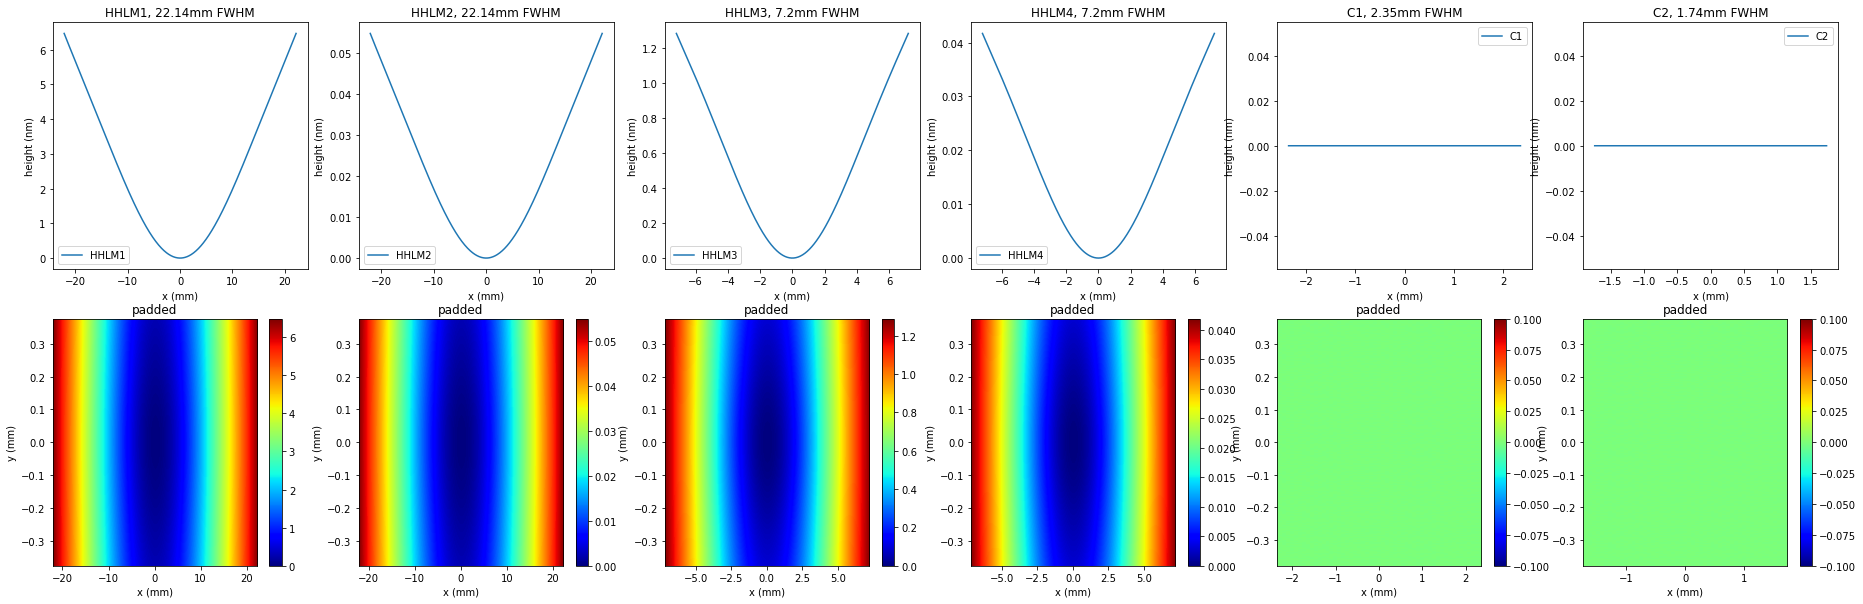

In [9]:
crystal_powers = np.array([30.8657, 0.2617, 2.9498, 0.1011, 0.1322, 0.0895])*0.5    # crytal power for 2DCM-111-220

crystal_powers *= np.array([1,1,1,1,0,0])



# get file name based on crystal powers
for i in range(n_crys):
    if i == 0:
        fname_error = ''
    if crystal_powers[i] != 0:
        fname_error += '{}_{}W_'.format(crystals[i], round(crystal_powers[i],3))
print(fname_error)

# directories
dir_profile = '../DXS_Xtals_FEA4WFS/{}/'.format(HHLM_type)

# holders
shapeErrors = [None for i in range(n_crys)]
x_mirs      = [None for i in range(n_crys)]
y_mirs      = [None for i in range(n_crys)]

if HHLM_type == 'Zigzag':
    crystal_profile_powers = np.array([
        [73.15, 16.53, 0.029, 0.027, 0.026, 0.03],
        [73.15, 16.79, 0.015, 0.015, 0.014, 0.013],
        [4.51, 50.1, 1.78, 1.69, 1.61, 1.88]
    ])
elif HHLM_type == '2DCM':
    crystal_profile_powers = np.array([
        [73.15, 0.027, 16.53, 0.029, 0.026, 0.03],
        [73.15, 0.015, 16.79, 0.015, 0.014, 0.013],
        [4.51, 1.69, 50.1, 1.78, 1.61, 1.88]
    ])

# choose which profile to use based on intended crystal power
ratio_power = crystal_profile_powers/np.stack([crystal_powers for i in range(3)])

for i in range(3):
    for j in range(n_crys):
        if ratio_power[i,j] <=1:
            ratio_power[i,j] = 1/ratio_power[i,j]

# pick the most similar case to scale up/down for each crystal
options = []
for i in range(n_crys):
    options.append(ratio_power[:,0].argmin()+1)

for i, crystal in enumerate(crystals):
    # load profiles from file
    dy, xx, zz = load_crystal_data(dir_profile, crystal, options[i])
    
    # change height linearly with power
    height_factor1 = crystal_powers[i] / crystal_profile_powers[options[i]-1, i]    
    
    # change height linearly with footprint
    height_factor2 = (l_crystal[i]/(xx.max()-xx.min()))*(w_crystal[i]/(zz.max()-zz.min()))*1e6

    shapeErrors[i] = dy * 1e6 * height_factor1 / height_factor2    # shapeErrors in [nm]
    x_mirs[i] = np.linspace(-l_crystal[i]/2, l_crystal[i]/2, xx.shape[0])
    y_mirs[i] = np.linspace(-w_crystal[i]/2, w_crystal[i]/2, xx.shape[1])

##### plots
plt.figure(figsize=(int(5*n_crys)+2, 10))
for i in range(n_crys):
    plt.subplot(2,n_crys, int(i+1))
    plt.plot(x_mirs[i]*1e3, shapeErrors[i][1024,:], label=crystals[i])
    plt.legend()
    plt.xlabel('x (mm)')
    plt.ylabel('height (nm)')
    plt.title('{}, {}mm FWHM'.format(crystals[i], round(l_crystal[i]/2*1e3,2)))
    plt.subplot(2,n_crys, n_crys+(int(i+1)))
    
    plt.imshow(shapeErrors[i], cmap='jet',
              extent = [x_mirs[i].min()*1e3, x_mirs[i].max()*1e3,
                        y_mirs[i].min()*1e3, y_mirs[i].max()*1e3])
    plt.colorbar()
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    plt.title('padded')
    plt.axis('tight')

for i in range(n_crys):
    if crystal_powers[i] == 0:
        shapeErrors[i] = None


### Profiles w/ & w/o shapeError at HHLM output

In [10]:
def define_beamline1(
    E0, m1_p=185.0, m2_p=175.5,
    HHLM_type='2DCM', HHLM_offset=20e-3, pair_distance=200e-3,
    slit_width=3e-6, f1=10.0, f2=10.0,
    hkl1 = [1,1,1], alphaAsym1 = 9.0,
    hkl2 = [3,3,3], alphaAsym2 = 0.0,
    shapeErrors=[None for i in range(6)],
    l_crystal=[1e-1 for i in range(6)],
    w_crystal = [5e-3 for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=5e-3, N=1024)
    
    Telescope_devices = define_Telescope(E0, m1_p=m1_p, m2_p=m2_p)
    
    if HHLM_type == '2DCM':
        HHLM_devices = define_HHLM_2DCM(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    elif HHLM_type == 'Zigzag':
        HHLM_devices = define_HHLM_Zigzag(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    im_out = optics.PPM('im_out', z=HHLM_devices[-1].z + 1e-3, FOV=5e-3, N=1024)
    
    all_devices = [im_input] + Telescope_devices + HHLM_devices + [im_out]
    
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return all_devices, mono_beamline


In [11]:
%%capture capt
##### w/o shapeError
mono_devices_p, mono_beamline_p = define_beamline1(E0,
                               m1_p=m1_p, m2_p=m2_p, HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=1e-1, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               shapeErrors=[None for i in range(6)],
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

beam_params['photonEnergy'] = E0
b1_p = beam.Beam(beam_params=beam_params)
b2_p = mono_beamline_p.propagate_beamline(b1_p)

In [12]:
%%capture capt
##### w/ shapeError
mono_devices_e, mono_beamline_e = define_beamline1(E0,
                           m1_p=m1_p, m2_p=m2_p, HHLM_type=HHLM_type,
                           slit_width=1e-1, f1=f1, f2=f2,
                           hkl1=hkl1, alphaAsym1=alphaAsym1,
                           hkl2=hkl2, alphaAsym2=alphaAsym2,
                           shapeErrors=shapeErrors,
                           l_crystal=l_crystal,
                           w_crystal=w_crystal)

beam_params['photonEnergy'] = E0
b1_e = beam.Beam(beam_params=beam_params)
b2_e = mono_beamline_e.propagate_beamline(b1_e)

### Get phase information from HHLM outputs w/ & w/o shapeError

Text(0, 0.5, 'y (mm)')

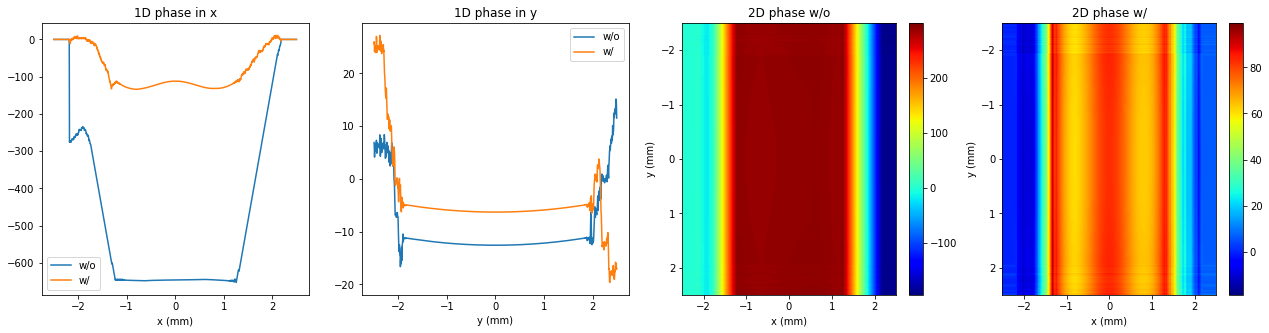

In [13]:
# get output image plane
ppm_p = mono_beamline_p.im_out
ppm_e = mono_beamline_e.im_out

# 1D phase info
phase_p_x = ppm_p.x_phase
phase_p_y = ppm_p.y_phase
phase_e_x = ppm_e.x_phase
phase_e_y = ppm_e.y_phase

# phase_p_x -= np.median(phase_p_x)
# phase_p_y -= np.median(phase_p_y)
# phase_e_x -= np.median(phase_e_x)
# phase_e_y -= np.median(phase_e_y)

# 2D phase info
phase_p_2d = np.unwrap(np.angle(ppm_p.complex_beam()[0]))
phase_e_2d = np.unwrap(np.angle(ppm_e.complex_beam()[0]))

# phase_p_2d -= np.median(phase_p_2d)
# phase_e_2d -= np.median(phase_e_2d)

# plots
plt.figure(figsize=(22,5))
plt.subplot(1,4,1)
plt.plot(ppm_p.x*1e3, phase_p_x, label='w/o')
plt.plot(ppm_e.x*1e3, phase_e_x, label='w/')
plt.legend()
plt.title('1D phase in x'); plt.xlabel('x (mm)')
# plt.xlim([-wx4*1e3, wx4*1e3])

plt.subplot(1,4,2)
plt.plot(ppm_p.y*1e3, phase_p_y, label='w/o')
plt.plot(ppm_e.y*1e3, phase_e_y, label='w/')
plt.legend()
plt.title('1D phase in y'); plt.xlabel('y (mm)')
# plt.xlim([-wy4*1e3, wy4*1e3])

plt.subplot(1,4,3)
plt.imshow(phase_p_2d, cmap='jet',
           extent = [ppm_p.x.min()*1e3, ppm_p.x.max()*1e3, ppm_p.y.max()*1e3, ppm_p.y.min()*1e3])
plt.colorbar()
plt.title('2D phase w/o'); plt.axis('tight')
plt.xlabel('x (mm)'); plt.ylabel('y (mm)')
# plt.xlim([-wx4*1e3, wx4*1e3]); plt.ylim([-wy4*1e3, wy4*1e3])

plt.subplot(1,4,4)
plt.imshow(phase_e_2d, cmap='jet',
           extent = [ppm_e.x.min()*1e3, ppm_e.x.max()*1e3, ppm_e.y.max()*1e3, ppm_e.y.min()*1e3])
plt.colorbar()
plt.title('2D phase w/'); plt.axis('tight')
plt.xlabel('x (mm)'); plt.ylabel('y (mm)')
# plt.xlim([-wx4*1e3, wx4*1e3]); plt.ylim([-wy4*1e3, wy4*1e3])


### Calculate phase difference and convert into phase plate thickness

Text(0, 0.5, 'y (mm)')

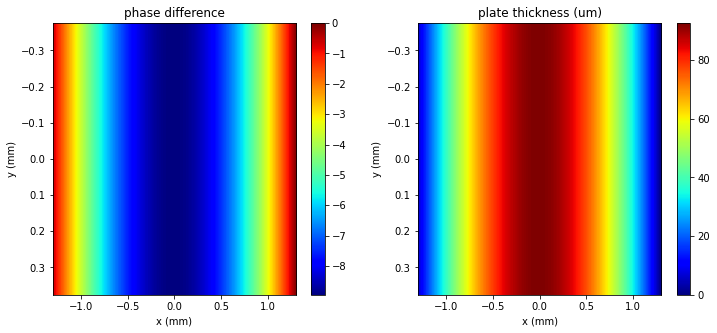

In [14]:
# phase difference
phaseMap = phase_p_2d - phase_e_2d

# crop roi based on beam width
index_x = np.where((ppm_p.x **2) < (wx4 ** 2))[0]
index_y = np.where((ppm_p.y **2) < (wy4 ** 2))[0]
phaseMap = phaseMap[index_x[0]:index_x[-1], index_y[0]:index_y[-1]]

phaseMap -= phaseMap.max()

# load material information from CXRO data
filename = os.path.join('../../LCLS/lcls_beamline_toolbox-beta/lcls_beamline_toolbox/xraybeamline2d/cxro_data/Be.csv')
cxro_data = np.genfromtxt(filename, delimiter=',')
energy = cxro_data[:, 0]; delta = cxro_data[:, 1]; beta = cxro_data[:, 2]
delta = np.interp(E0, energy, delta); beta = np.interp(E0, energy, beta)

# calculate thickness
plateThickness = -phaseMap * b2.lambda0 / (np.mean(delta)*2*np.pi)

# plots
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(phaseMap, cmap='jet',
           extent = [-wx4*1e3, wx4*1e3, wy4*1e3, -wy4*1e3])
plt.colorbar(); plt.axis('tight')
plt.title('phase difference')
plt.xlabel('x (mm)'); plt.ylabel('y (mm)')
# plt.clim(-50)

plt.subplot(1,2,2)
plt.imshow(plateThickness*1e6, cmap='jet',
           extent = [-wx4*1e3, wx4*1e3, wy4*1e3, -wy4*1e3])
plt.colorbar(); plt.axis('tight')
plt.title('plate thickness (um)')
plt.xlabel('x (mm)'); plt.ylabel('y (mm)')
# plt.clim([0, 300])

### new class for PhasePlate optics

In [15]:
class PhasePlate:
    """
    Attributes
    ----------
    name: str
        Name of the device (e.g. CRL1)
    plateThickness: float
        Thickness profile of the phase plate. (meters)
    x_plate: float
        Phase plate size in x. (meters)
    y_plate: float
        Phase plate size in y. (meters)
    E0: float or None
        photon energy in eV for calculating the corresponding phase difference of a given thickness
    material: str
        Phase plate material. Currently only Be is implemented but may add CVD diamond in the future.
        Looks up downloaded data from CXRO.
    dx: float
        Phase plate de-centering along beam's x-axis.
    dy: float
        Phase plate de-centering along beam's y-axis.
    z: float
        z location of phase plate along beamline.
    energy: (N,) ndarray
        List of photon energies from CXRO file (eV).
    delta: (N,) ndarray
        Real part of index of refraction. n = 1 - delta + 1j * beta
    beta: (N,) ndarray
        Imaginary part of index of refraction. n = 1 - delta + 1j * beta
    """
    
    def __init__(self, name, plateThickness=None, x_plate=None, y_plate=None, E0=None, material='Be', z=0, dx=0, orientation=0):
        """
        Method to create a PhasePlate object.
        :param name: str
            Name of the device (e.g. Phase1)
        :param plateThickness: float
            Thickness profile of the phase plate. (meters)
        :x_plate: float
            Phase plate size in x. (meters)
        :y_plate: float
            Phase plate size in y. (meters)
        :param E0: float
            photon energy for calculating radius of curvature for a given focal length (eV)
        :param material: str
            Lens material. Currently only Be is implemented but may add CVD diamond in the future.
            Looks up downloaded data from CXRO.
        :param z: float
            z location of lenses along beamline.
        :param dx: float
            PhasePlate de-centering along beam's x-axis.
        :param orientation: int
            Whether or not this is a horizontal or vertical lens (0 for horizontal, 1 for vertical).
        """
        
        # set some attributes
        self.name = name
        self.plateThickness = plateThickness
        self.x_plate = x_plate
        self.y_plate = y_plate
        self.E0 = E0
        self.material = material
        self.dx = dx
        self.z = z
        self.global_x = 0
        self.global_y = 0
        self.orientation = orientation
        self.azimuth = 0
        self.elevation = 0
        self.xhat = None
        self.yhat = None
        self.zhat = None

        # get file name of CXRO data
        filename = os.path.join('../../LCLS/lcls_beamline_toolbox-beta/lcls_beamline_toolbox/xraybeamline2d/cxro_data/Be.csv')

        # load in CXRO data
        cxro_data = np.genfromtxt(filename, delimiter=',')
        self.energy = cxro_data[:, 0]
        self.delta = cxro_data[:, 1]
        self.beta = cxro_data[:, 2]

    def multiply(self, beam):
        """
        Method to propagate beam through PhasePlate
        :param beam: Beam
            Beam object to propagate through PhasePlate. Beam is modified by this method.
        :return: None
        """
        
        # get shape of phase plate thickness
        self.plate_shape = np.shape(self.plateThickness)
        Ms = self.plate_shape[0]; Ns = self.plate_shape[1]
        
        if self.orientation == 0:
            beamx = beam.x
            beamz = beam.zx
            beamc = beam.cx
            size_plate = self.x_plate
            central_line = self.plateThickness[np.int(Ms/2)]
        else:
            beamx = beam.y
            beamz = beam.zy
            beamc = beam.cy
            xs = self.y_plate
            size_plate = self.y_plate
            central_line = self.plateThickness[:, np.int(Ns/2)]
        
        Ms = central_line.size
        xs = np.linspace(-Ms/2, Ms/2 -1, Ms) * size_plate/Ms    # phase plate x coordinate
        
        # interpolation onto beam coordinates
        thickness = np.interp(beamx - self.dx, xs, central_line)

        # interpolate to find index of refraction at beam's energy
        delta = np.interp(beam.photonEnergy, self.energy, self.delta)
        beta = np.interp(beam.photonEnergy, self.energy, self.beta)
        phase = -beam.k0 * delta * thickness
        
        # transmission based on beta and thickness profile
        mask = (((beamx - self.dx) ** 2) < (size_plate / 2) ** 2).astype(float)
        transmission = np.exp(-beam.k0 * beta * thickness) * np.exp(1j * phase) * mask

        if self.orientation == 0:
            beam.wavex *= transmission
        else:
            beam.wavey *= transmission

    def propagate(self, beam):
        """
        Method to propagate beam through PhasePlate. Calls multiply.
        :param beam: Beam
            Beam object to propagate through PhasePlate. Beam is modified by this method.
        :return: None
        """
        self.multiply(beam)


### Profile with phase plate implemented

In [16]:
def define_beamline_c(
    E0, m1_p=185.0, m2_p=175.5,
    HHLM_type='2DCM', HHLM_offset=20e-3, pair_distance=200e-3,
    slit_width=3e-6, f1=10.0, f2=10.0,
    hkl1 = [1,1,1], alphaAsym1 = 0.0,
    hkl2 = [2,2,0], alphaAsym2 = 0.0,
    hkl3 = [5,5,5], alphaAsym3 = 15.0,
    shapeErrors=[None for i in range(6)],
    l_crystal=[1e-1 for i in range(6)],
    w_crystal = [5e-3 for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=5e-3, N=512)
    
    Telescope_devices = define_Telescope(E0, m1_p=m1_p, m1_q=25.6, m2_p=m2_p)
    
    if HHLM_type == '2DCM':
        HHLM_devices = define_HHLM_2DCM(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    elif HHLM_type == 'Zigzag':
        HHLM_devices = define_HHLM_Zigzag(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    
    Phase1 = PhasePlate('Phase1', plateThickness=plateThickness, x_plate=wx4*2, y_plate=wy4*2, E0=E0, orientation=0, z=HHLM_devices[-1].z + 1e-3)
    
    im_out = 
#     HRM_devices = define_HRM(E0, f1=f1, f2=f2, slit_width=slit_width,
#                             hkl=hkl3, alphaAsym=alphaAsym3,
#                             shapeErrors=shapeErrors,
#                             l_crystal=l_crystal,
#                             w_crystal=w_crystal)

    all_devices = [im_input] + Telescope_devices + HHLM_devices + [Phase1] + HRM_devices
    
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return all_devices, mono_beamline


In [17]:
%%capture capt
mono_devices_c, mono_beamline_c = define_beamline_c(E0,
                           m1_p=m1_p, m2_p=m2_p, HHLM_type=HHLM_type,
                           slit_width=slit_width, f1=f1, f2=f2,
                           hkl1=hkl1, alphaAsym1=alphaAsym1,
                           hkl2=hkl2, alphaAsym2=alphaAsym2,
                           hkl3=hkl3, alphaAsym3=alphaAsym3,
                           shapeErrors=shapeErrors,
                           l_crystal=l_crystal,
                           w_crystal=w_crystal)

screen_names = ['im_input', 'im_after_T1', 'im_after_T2', 'im_after_HHLM1', 'im_after_HHLM2', 'im_after_HHLM3', 'im_after_HHLM4',
    'im_after_C1','im_after_C2','im_before_MIR1','im_after_MIR1','im_focus','im_before_MIR2','im_after_MIR2','im_after_C3','im_out']

beam_params['photonEnergy'] = E0
b1_c = beam.Beam(beam_params=beam_params)
b2_c = mono_beamline_c.propagate_beamline(b1_c)

### Re-simulate profiles w/ & w/o shapeError for comparison

In [18]:
%%capture capt
##### w/o shapeError
mono_devices_p, mono_beamline_p = define_beamline0(E0,
                               m1_p=m1_p, m2_p=m2_p, HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=1e-1, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=[None for i in range(6)],
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

beam_params['photonEnergy'] = E0
b1_p = beam.Beam(beam_params=beam_params)
b2_p = mono_beamline_p.propagate_beamline(b1_p)

In [19]:
%%capture capt
##### w/ shapeError
mono_devices_e, mono_beamline_e = define_beamline0(E0,
                               m1_p=m1_p, m2_p=m2_p, HHLM_type=HHLM_type,
                               slit_width=1e-1, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=shapeErrors,
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

beam_params['photonEnergy'] = E0
b1_e = beam.Beam(beam_params=beam_params)
b2_e = mono_beamline_e.propagate_beamline(b1_e)

### Plot

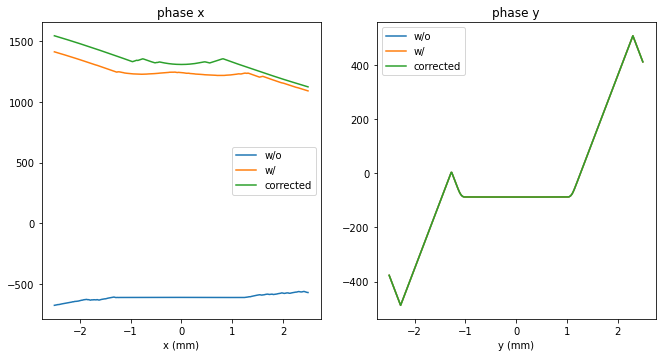

In [22]:
##### phase for the perfect case
ppm_p = mono_beamline_p.im_out
ppm_e = mono_beamline_e.im_out
ppm_c = mono_beamline_c.im_out

# 1D
plt.figure(figsize=(17,12))
plt.subplot(2,3,1)
plt.plot(ppm_p.x*1e3, ppm_p.x_phase, label='w/o')
plt.plot(ppm_e.x*1e3, ppm_e.x_phase, label='w/')
plt.plot(ppm_c.x*1e3, ppm_c.x_phase, label='corrected')
plt.title('phase x'); plt.xlabel('x (mm)')
plt.legend()

plt.subplot(2,3,2)
plt.plot(ppm_p.y*1e3, ppm_p.y_phase, label='w/o')
plt.plot(ppm_e.y*1e3, ppm_e.y_phase, label='w/')
plt.plot(ppm_c.y*1e3, ppm_c.y_phase, label='corrected')
plt.title('phase y'); plt.xlabel('y (mm)')
plt.legend()


In [21]:
import winsound
winsound.Beep(1500, 3000)